#### quest
 - 업무분장(전처리, 모델학습)
 - RecurrenceOfSurgery.csv 사용
 - 목표변수 범주형 : 척추전방위증 
 - 설명변수 최소 6개 : 
   - (연속형)
     체중 
     신장
        
   - (범주형)
     환자통증정도,
     스테로이드치료, 
     수술기법
     과거수술횟수
  
- 서비스 대상과 목표 설명, 변수 선택 이유

In [79]:
import pandas as pd

In [80]:
df_ROS = pd.read_csv('../datasets/RecurrenceOfSurgery.csv')
df_ROS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894 entries, 0 to 1893
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              1894 non-null   int64  
 1   환자ID                    1894 non-null   object 
 2   Large Lymphocyte        1894 non-null   float64
 3   Location of herniation  1894 non-null   int64  
 4   ODI                     462 non-null    float64
 5   가족력                     1843 non-null   float64
 6   간질성폐질환                  1894 non-null   int64  
 7   고혈압여부                   1894 non-null   int64  
 8   과거수술횟수                  1894 non-null   int64  
 9   당뇨여부                    1894 non-null   int64  
 10  말초동맥질환여부                1894 non-null   int64  
 11  빈혈여부                    1894 non-null   int64  
 12  성별                      1894 non-null   int64  
 13  스테로이드치료                 1894 non-null   int64  
 14  신부전여부                   1894 non-null   

In [81]:
df_ROS[:2]

,Unnamed: 0,환자ID,Large Lymphocyte,Location of herniation,ODI,가족력,간질성폐질환,고혈압여부,과거수술횟수,당뇨여부,...,Modic change,PI,PT,Seg Angle(raw),Vaccum disc,골밀도,디스크단면적,디스크위치,척추이동척도,척추전방위증
0,0,1PT,22.8,3,51.0,0.0,0,0,0,0,...,3,51.6,36.6,14.4,0,-1.01,2048.5,4,Down,0
1,1,2PT,44.9,4,26.0,0.0,0,0,0,0,...,0,40.8,7.2,17.8,0,-1.14,1753.1,4,Up,0


In [82]:
df_ROS.columns

Index(['Unnamed: 0', '환자ID', 'Large Lymphocyte', 'Location of herniation',
       'ODI', '가족력', '간질성폐질환', '고혈압여부', '과거수술횟수', '당뇨여부', '말초동맥질환여부', '빈혈여부',
       '성별', '스테로이드치료', '신부전여부', '신장', '심혈관질환', '암발병여부', '연령', '우울증여부', '입원기간',
       '입원일자', '종양진행여부', '직업', '체중', '퇴원일자', '헤모글로빈수치', '혈전합병증여부', '환자통증정도',
       '흡연여부', '통증기간(월)', '수술기법', '수술시간', '수술실패여부', '수술일자', '재발여부', '혈액형',
       '전방디스크높이(mm)', '후방디스크높이(mm)', '지방축적도', 'Instability', 'MF + ES',
       'Modic change', 'PI', 'PT', 'Seg Angle(raw)', 'Vaccum disc', '골밀도',
       '디스크단면적', '디스크위치', '척추이동척도', '척추전방위증'],
      dtype='object')

In [83]:
df_ROS_extract_null = df_ROS[['척추전방위증', '체중', '신장', '환자통증정도', '스테로이드치료', '수술기법', '과거수술횟수']]
df_ROS_extract_null.isnull().sum() # 결측치 확인 

척추전방위증      0
체중          0
신장          0
환자통증정도      0
스테로이드치료     0
수술기법       81
과거수술횟수      0
dtype: int64

In [84]:
df_ROS_extract_null[:2]

,척추전방위증,체중,신장,환자통증정도,스테로이드치료,수술기법,과거수술횟수
0,0,60.3,163,10,1,TELD,0
1,0,71.7,171,10,1,TELD,0


In [85]:
df_ROS_extract_null['수술기법'].value_counts()

TELD    1673
IELD     140
Name: 수술기법, dtype: int64

### 결측치 예측 훈련 모델 생성['수술기법']

In [86]:
from sklearn.linear_model import LogisticRegression

In [87]:
# 원본 데이터프레임에서 '수술기법' 열을 추출
df_ROS_extract_null['수술기법']

0       TELD
1       TELD
2       TELD
3       TELD
4       TELD
        ... 
1889     NaN
1890     NaN
1891    IELD
1892     NaN
1893     NaN
Name: 수술기법, Length: 1894, dtype: object

In [88]:
# 결측치를 예측하는 함수
def predict_surgery_method(row):
    if pd.isnull(row['수술기법']):
        # 결측치를 예측하기 위해 사용할 특성 선택 (이 예제에서는 다른 열을 모두 사용)
        features = df_ROS_extract_null.columns.tolist()
        features.remove('수술기법')  # 예측에 사용할 특성에서 '수술기법' 열 제외
        X = df_ROS_extract_null.loc[row.name, features].values.reshape(1, -1)
        
        # 학습 데이터에서 수술기법이 결측치인 행 제외
        df_train = df_ROS_extract_null.dropna(subset=['수술기법'])
        
        # 훈련용 데이터셋과 타겟 생성
        features_train = df_train[features].values
        target_train = df_train['수술기법'].values
        
        # 로지스틱 회귀 모델 훈련 (결측치 예측, 수술기법의 결측치를 대체하기 위한 용도)
        missing_value_imputation_model = LogisticRegression()
        missing_value_imputation_model.fit(features_train, target_train)
        
        # 결측치 대체를 위한 예측
        predicted_nan = model.predict(X)
        
        # 예측 결과를 반환
        return predicted_nan[0]
    else:
        return row['수술기법']

In [89]:
# apply를 사용하여 함수 적용하여 결측치 처리
df_ROS_extract_null.loc[:, '수술기법'] = df_ROS_extract_null.apply(lambda row: predict_surgery_method(row), axis=1)

C:\Users\04-02\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\04-02\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\04-02\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\04-02\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\04-02\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\04-02\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X d

In [90]:
df_ROS_extract_null.isnull().sum() 

척추전방위증     0
체중         0
신장         0
환자통증정도     0
스테로이드치료    0
수술기법       0
과거수술횟수     0
dtype: int64

In [91]:
df_ROS_extract_null['수술기법'].value_counts()

TELD    1754
IELD     140
Name: 수술기법, dtype: int64

In [92]:
df_ROS_extract_null[:2]

,척추전방위증,체중,신장,환자통증정도,스테로이드치료,수술기법,과거수술횟수
0,0,60.3,163,10,1,TELD,0
1,0,71.7,171,10,1,TELD,0


In [93]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [94]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from imblearn.under_sampling import TomekLinks

In [95]:
# 수술기법이 결측치인 행 추출
nan_rows = df_ROS_extract_null[pd.isnull(df_ROS_extract_null['수술기법'])]

In [96]:
# 결측치가 아닌 행 추출
not_nan_rows = df_ROS_extract_null.dropna(subset=['수술기법'])

In [97]:
# Features와 Target 설정
features = not_nan_rows.drop(columns=['수술기법'])
target = not_nan_rows['수술기법']

In [98]:
# Tomek's Link 언더샘플링을 적용
tl = TomekLinks(sampling_strategy='majority')
features_resampled, target_resampled = tl.fit_resample(features, target)

In [99]:
# 데이터 분할 (70% 학습, 30% 테스트)
features_train, features_test, target_train, target_test = train_test_split(features_resampled, target_resampled, test_size=0.3, random_state=42)

In [100]:
# 로지스틱 회귀 모델 생성 및 학습 (모델 평가, 결측치 예측 모델 평가를 위해 사용)
Evaluation_model = LogisticRegression()
model.fit(features_train, target_train)

C:\Users\04-02\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [101]:
# 모델을 사용하여 결측치 예측
predicted_nan_values = nan_rows.apply(predict_surgery_method, axis=1)

In [102]:
# 결측치 예측 결과를 원본 데이터프레임에 할당
df_ROS_extract_null.loc[nan_rows.index, '수술기법'] = predicted_nan_values

In [103]:
# 결측치 예측 모델 평가 accuracy 
target_pred = model.predict(features_test)
accuracy = accuracy_score(target_test, target_pred)
print("결측치 예측 모델 정확도:", accuracy)

결측치 예측 모델 정확도: 0.9201451905626135


In [104]:
# 결측치 예측 모델 평가 - F1 점수 계산
target_pred = model.predict(features_test)
f1 = f1_score(target_test, target_pred, average='weighted')
print("결측치 예측 모델 F1 점수:", f1)

결측치 예측 모델 F1 점수: 0.8818782828265501


### 신장, 체중 이상치 제거

In [105]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [106]:
# 한글 폰트를 지정
font_path = "C:/Windows/Fonts/malgun.ttf" 
font_prop = fm.FontProperties(fname=font_path, size=14)

# 그래프에서 한글을 사용할 때 폰트 설정
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

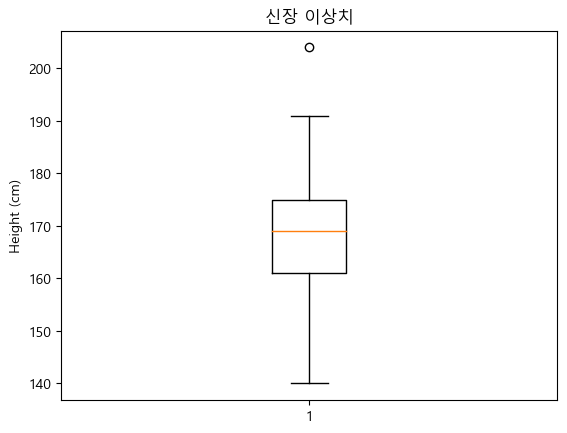

In [107]:
# 신장 데이터에 대한 상자 그림
plt.boxplot(df_ROS_extract_null['신장'])
plt.title('신장 이상치')
plt.ylabel('Height (cm)')
plt.show()

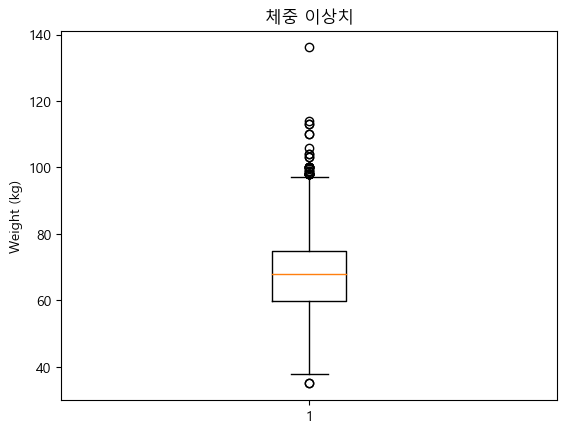

In [108]:
# 체중 데이터에 대한 상자 그림
plt.boxplot(df_ROS_extract_null['체중'])
plt.title('체중 이상치')
plt.ylabel('Weight (kg)')
plt.show()

In [109]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_cleaned = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return df_cleaned

In [110]:
# "신장" 열의 이상치 제거
df_ROS_extract_null = remove_outliers(df_ROS_extract_null, '신장')

In [111]:
# "체중" 열의 이상치 제거
df_ROS_extract_null = remove_outliers(df_ROS_extract_null, '체중')

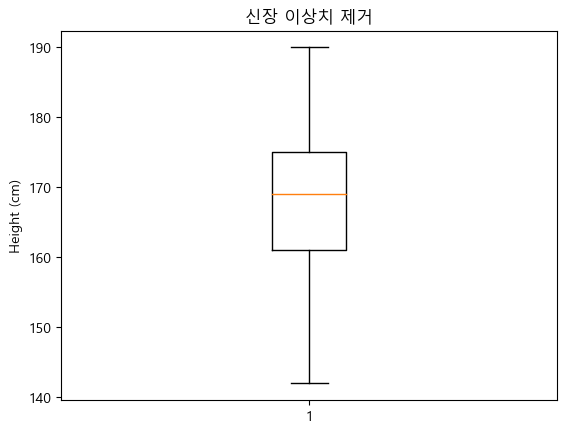

In [112]:
plt.boxplot(df_ROS_extract_null['신장'])
plt.title('신장 이상치 제거')
plt.ylabel('Height (cm)')
plt.show()

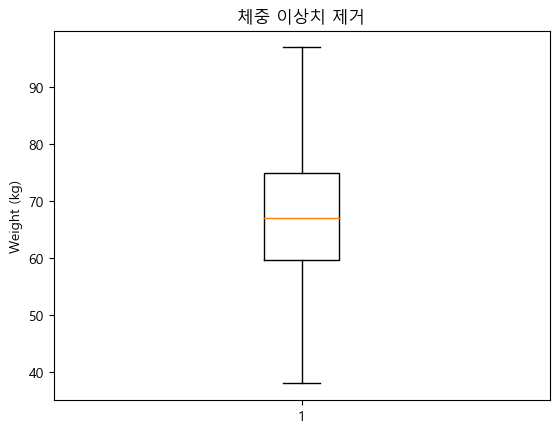

In [113]:
# 체중 데이터에 대한 상자 그림
plt.boxplot(df_ROS_extract_null['체중'])
plt.title('체중 이상치 제거')
plt.ylabel('Weight (kg)')
plt.show()

### Scaling & Encoding

In [114]:
df_ROS_extract_null.value_counts()

척추전방위증  체중    신장   환자통증정도  스테로이드치료  수술기법  과거수술횟수
0       73.8  174  7       1        TELD  0         4
        62.0  170  7       1        TELD  0         3
              180  8       1        TELD  0         3
        59.7  161  8       1        TELD  0         3
        59.6  161  7       1        TELD  0         3
                                                   ..
        63.0  152  7       1        TELD  0         1
                   1       0        TELD  0         1
              150  2       1        TELD  0         1
        62.8  159  9       1        TELD  0         1
1       93.0  175  8       0        TELD  0         1
Length: 1715, dtype: int64

In [115]:
df_ROS_extract_null.shape

(1861, 7)

### OneHotEncoding : 수술기법  범주형 데이터를 수치형 데이터로 변환

In [116]:
from sklearn.preprocessing import OneHotEncoder

In [117]:
oneHotEncoder = OneHotEncoder()
oneHotEncoder.fit(df_ROS_extract_null[['수술기법']]) 

OneHotEncoder()

In [118]:
columns_name = oneHotEncoder.categories_

In [119]:
# oneHotEncoder.transform(df_TFD_extract_preprocess[['Pclass']]).toarray() # 실제값 확인용
encoded_data = oneHotEncoder.transform(df_ROS_extract_null[['수술기법']]).toarray()

In [120]:
encoded_data.shape

(1861, 2)

In [121]:
# 병합 위해 numpy array to DataFrame
df_encoded_data = pd.DataFrame(data=encoded_data, columns=oneHotEncoder.get_feature_names_out(['수술기법']))
df_encoded_data[:2]

,수술기법_IELD,수술기법_TELD
0,0.0,1.0
1,0.0,1.0


In [122]:
df_ROS_extract_encoded = pd.concat([df_ROS_extract_null.reset_index(drop=True)
                                       , df_encoded_data.reset_index(drop=True)], axis=1)
df_ROS_extract_encoded[:2]

,척추전방위증,체중,신장,환자통증정도,스테로이드치료,수술기법,과거수술횟수,수술기법_IELD,수술기법_TELD
0,0,60.3,163,10,1,TELD,0,0.0,1.0
1,0,71.7,171,10,1,TELD,0,0.0,1.0


In [123]:
df_encoded_data.index, df_encoded_data.shape

(RangeIndex(start=0, stop=1861, step=1), (1861, 2))

In [124]:
df_ROS_extract_null.index, df_ROS_extract_null.shape

(Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893],
            dtype='int64', length=1861),
 (1861, 7))

In [125]:
df_ROS_extract_encoded.shape

(1861, 9)

In [126]:
df_ROS_extract_encoded.columns

Index(['척추전방위증', '체중', '신장', '환자통증정도', '스테로이드치료', '수술기법', '과거수술횟수',
       '수술기법_IELD', '수술기법_TELD'],
      dtype='object')

In [127]:
target = df_ROS_extract_encoded[['척추전방위증']]

In [128]:
features = df_ROS_extract_encoded.drop(columns=['척추전방위증','수술기법'])

In [129]:
features.columns

Index(['체중', '신장', '환자통증정도', '스테로이드치료', '과거수술횟수', '수술기법_IELD', '수술기법_TELD'], dtype='object')

### MinMaxScaler

In [130]:
from sklearn.preprocessing import MinMaxScaler

In [131]:
minMaxScaler = MinMaxScaler() # 인스턴스화
features = minMaxScaler.fit_transform(features)
features.shape

(1861, 7)

### 정형화 단계 (민정언니꺼 붙이기!!)

In [132]:
from sklearn.model_selection import train_test_split

In [133]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=111)
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((1395, 7), (1395, 1), (466, 7), (466, 1))